# Gaussian Mixture Model Evaluation

In [1]:
import sys
import os

# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from src.gaussian_mixture_model import GMM

# 1. Generate Synthetic Data

In [3]:
# Set seed for reproducibility
np.random.seed(42) 

# K: number of components (Gaussian)
# D: dimension of each Gaussian
n_samples = 500

# 1D example
# true_means = np.array([[-5], [0], [5]]) # (K, D) - mean of each gaussian at each dimension
# true_stds = np.array([[0.8], [1.0], [0.5]]) # (K, D) - std of each gaussian at each dimension
# true_weights = np.array([0.3, 0.4, 0.3]) # (K,) - weight of each gaussian

# 2D example
true_means = np.array([[-5, -2], [0, 2], [5, 5]]) # (K, D) - mean of each gaussian at each dimension
true_stds = np.array([[0.8, 0.3], [1.0, 0.3], [0.5, 1.0]]) # (K, D) - std of each gaussian at each dimension
true_weights = np.array([0.3, 0.4, 0.3]) # (K,) - weight of each gaussian

true_variances = true_stds**2

print(f"Shape of true_means = {true_means.shape}")
print(f"Shape of true_variances = {true_variances.shape}")
print(f"Shape of true_weights = {true_weights.shape}")

true_K = true_means.shape[0] # number of components
D = true_means.shape[1] # dimension
print(f"K = {true_K}")
print(f"D = {D}")

# Create synthetic dataset
data = np.concatenate([
    np.random.normal(loc=mean, scale=std, size=(int(weight * n_samples), D)) 
    for mean, std, weight in zip(true_means, true_stds, true_weights)
], axis=0)
print(f"Shape of data = {data.shape}")

Shape of true_means = (3, 2)
Shape of true_variances = (3, 2)
Shape of true_weights = (3,)
K = 3
D = 2
Shape of data = (500, 2)


### 1.1 True PDF

Plot the true pdf of the generated data at each dimension

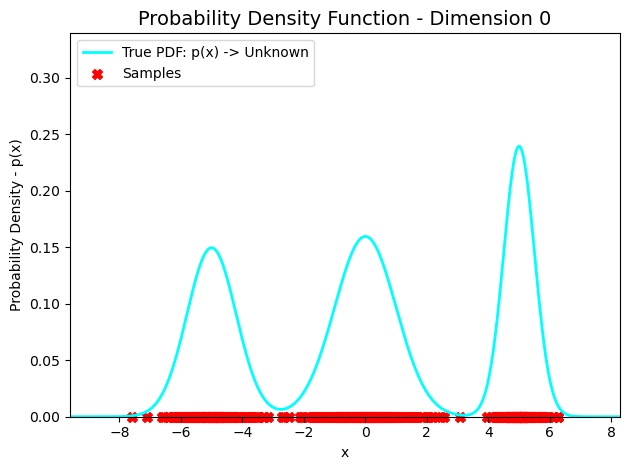

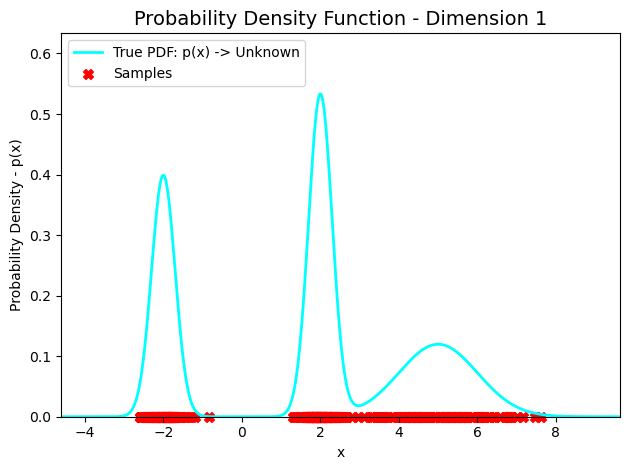

In [4]:
# Plot True pdf at each dimension
for d in range(D):
    x_values = np.linspace(min(data[:, d]) - 2, max(data[:, d]) + 2, 1000)

    density = np.zeros_like(x_values)
    for k in range(true_K):
        pdf = (1 / np.sqrt(2 * np.pi * true_variances[k, d])) * np.exp(-0.5 * ((x_values - true_means[k, d])**2) / true_variances[k, d])
        density += (true_weights[k] * pdf)
    plt.plot(x_values, density, color='cyan', linewidth=2, label='True PDF: p(x) -> Unknown')

    # Plot samples from the pdf
    plt.scatter(data[:, d], np.zeros_like(data[:, d]), c='red', marker='X', s=50, label='Samples', clip_on=False)

    plt.title(f'Probability Density Function - Dimension {d}', fontsize=14)
    plt.ylabel('Probability Density - p(x)')
    plt.xlabel('x')
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.xlim(min(data[:, d]) - 2, max(data[:, d]) + 2)
    plt.ylim(0.0, max(density) + 0.1)
    plt.tight_layout()
    plt.show()

## 2. Train GMMs 

In [5]:
# Dictionary of models to train and evaluate
K = 3
D = data.shape[1]

models = {
    "GMM (Scratch)": GMM(K=K, D=D),
    "GMM (Sklearn)": GaussianMixture(n_components=K, covariance_type='full', random_state=42)
}

In [6]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f'Training model: {name}')
    model.fit(data)
    Y_pred = model.predict(data)

    # Compute performance metrics
    silh_score = silhouette_score(data, Y_pred)
    davies_score = davies_bouldin_score(data, Y_pred)
    calinski_score= calinski_harabasz_score(data, Y_pred)
    results[name] = {
        "Silhouette-Score": silh_score,
        "Davies-Bouldin-Score": davies_score,
        "Calinski-Harabasz-Score": calinski_score
    }

Training model: GMM (Scratch)
Converged after 7 iterations
Training model: GMM (Sklearn)


In [7]:
# Compare model performance
print("Model Performance Comparison:")
performance_df = pd.DataFrame(results).T
print(performance_df)

Model Performance Comparison:
               Silhouette-Score  Davies-Bouldin-Score  Calinski-Harabasz-Score
GMM (Scratch)          0.790151               0.28999              5464.541317
GMM (Sklearn)          0.790151               0.28999              5464.541317


### 2.1.1 Convergence Analysis (Scratch)

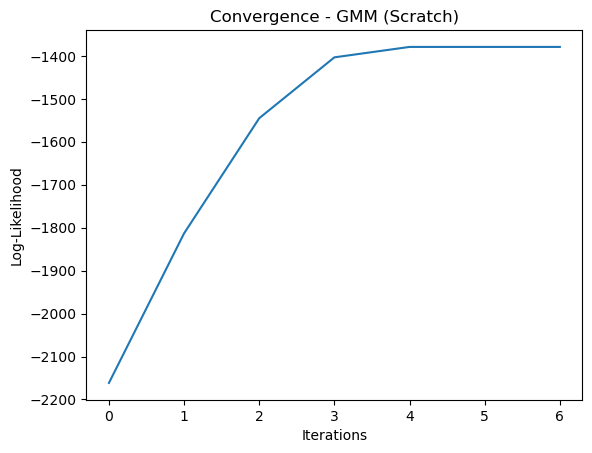

In [8]:
plt.plot(models['GMM (Scratch)'].nll_history)
plt.xlabel("Iterations")
plt.ylabel("Log-Likelihood")
plt.title("Convergence - GMM (Scratch)")
plt.show()

## 3. Model Evaluation

### 3.1.2 Cluster Assignments (Scratch)

Log-Likelihood: -1379.1299008271499


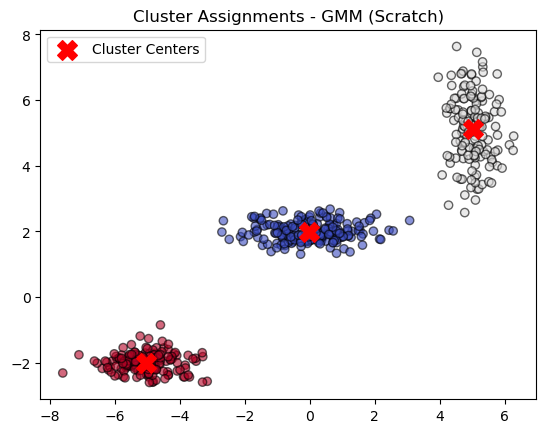

In [9]:
# Predict cluster assignments
scratch_preds = models['GMM (Scratch)'].predict(data)

# Compute log-likelihood of the fitted model
scratch_log_likelihood = models['GMM (Scratch)'].nll_history[-1]
print(f'Log-Likelihood: {scratch_log_likelihood}')

# Visualize Clusters
plt.scatter(data[:, 0], data[:, 1], c=scratch_preds, cmap='coolwarm', marker='o', edgecolors='k', alpha=0.6)
plt.scatter(models['GMM (Scratch)'].means[:, 0], models['GMM (Scratch)'].means[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('Cluster Assignments - GMM (Scratch)')
plt.legend()
plt.show()

### 3.1.2 Cluster Assignments (Sklearn)

Log-Likelihood: -1378.3854187225088, BIC: 2862.4191751181947, AIC: 2790.7708374450176


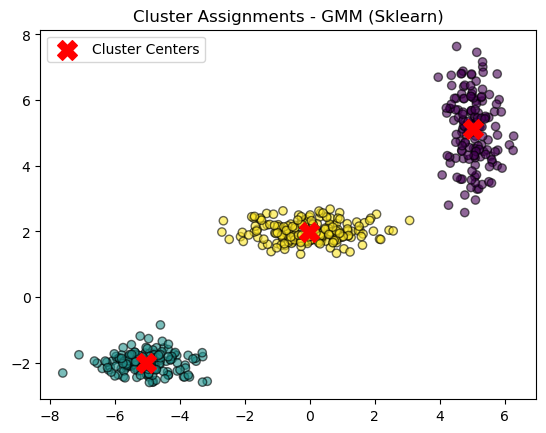

In [10]:
# Predict cluster assignments
sklearn_preds = models['GMM (Sklearn)'].predict(data)

# Compute log-likelihood of the fitted model
sklearn_log_likelihood = models['GMM (Sklearn)'].score(data) * len(data)
bic = models['GMM (Sklearn)'].bic(data)
aic = models['GMM (Sklearn)'].aic(data)
print(f'Log-Likelihood: {sklearn_log_likelihood}, BIC: {bic}, AIC: {aic}')

# Visualize Clusters
plt.scatter(data[:, 0], data[:, 1], c=sklearn_preds, cmap='viridis', marker='o', edgecolors='k', alpha=0.6)
plt.scatter(models['GMM (Sklearn)'].means_[:, 0], models['GMM (Sklearn)'].means_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('Cluster Assignments - GMM (Sklearn)')
plt.legend()
plt.show()

### 3.2.1 True vs. Predicted PDF (Scratch)

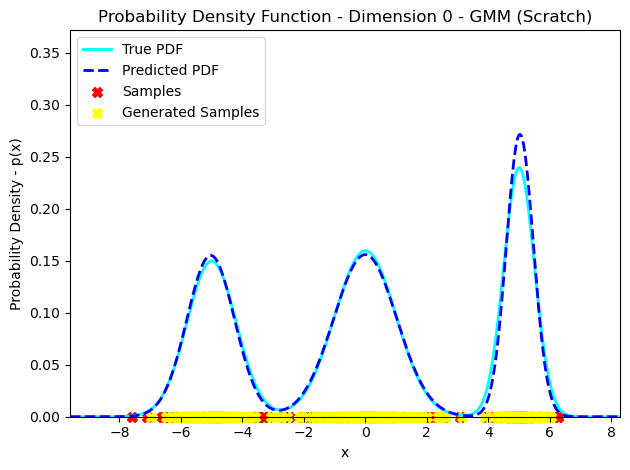

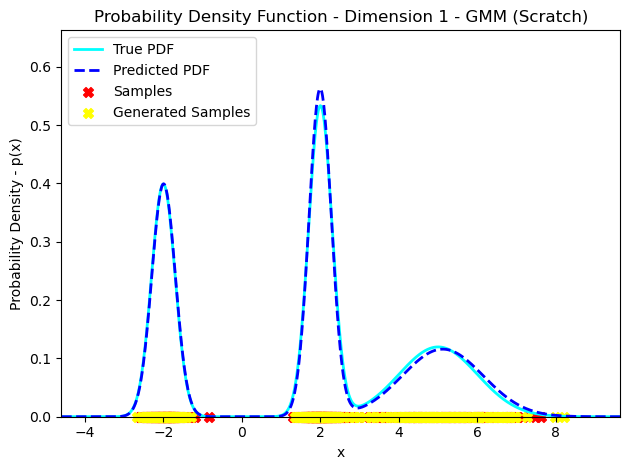

In [11]:
for d in range(D):
    x_values = np.linspace(min(data[:, d]) - 2, max(data[:, d]) + 2, 1000)

    # Plot true density
    density = np.zeros_like(x_values)
    for k in range(true_K):
        pdf = (1 / np.sqrt(2 * np.pi * true_variances[k, d])) * np.exp(-0.5 * ((x_values - true_means[k, d])**2) / true_variances[k, d])
        density += (true_weights[k] * pdf)
    plt.plot(x_values, density, color='cyan', linewidth=2, label='True PDF')

    # Plot predicted density
    pred_density = np.zeros_like(x_values)
    for k in range(K):
        pdf = (1 / np.sqrt(2 * np.pi * models['GMM (Scratch)'].variances[k, d])) * np.exp(-0.5 * ((x_values - models['GMM (Scratch)'].means[k, d])**2) / models['GMM (Scratch)'].variances[k, d])
        pred_density += (models['GMM (Scratch)'].weights[k] * pdf)
    plt.plot(x_values, pred_density, color='blue', linewidth=2, linestyle='--', label='Predicted PDF')

    # Plot samples generated from true density
    plt.scatter(data[:, d], np.zeros_like(data[:, d]), c='red', marker='X', s=50, label='Samples', clip_on=False)

    # Generate samples from the predicted density and plot
    data_samples = models['GMM (Scratch)'].sample(500)
    plt.scatter(data_samples[:, d], np.zeros_like(data_samples[:, d]), c='yellow', marker='X', s=50, label='Generated Samples', clip_on=False)

    plt.title(f'Probability Density Function - Dimension {d} - GMM (Scratch)', fontsize=12)
    plt.ylabel('Probability Density - p(x)')
    plt.xlabel('x')
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.xlim(min(data[:, d]) - 2, max(data[:, d]) + 2)
    plt.ylim(0.0, max(max(density), max(pred_density)) + 0.1)
    plt.tight_layout()
    plt.show()

### 3.2.2 True vs. Predicted PDF (Sklearn)

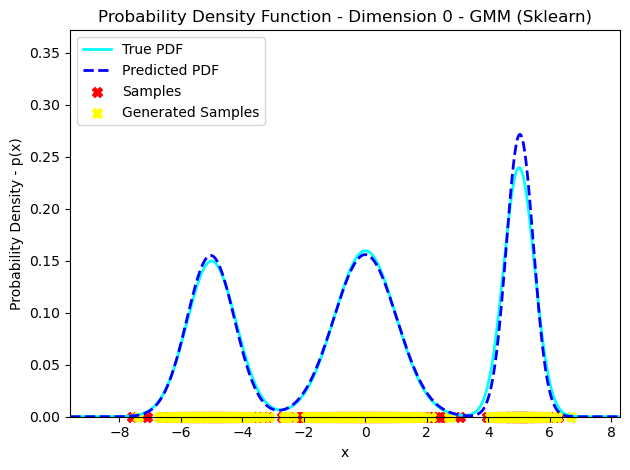

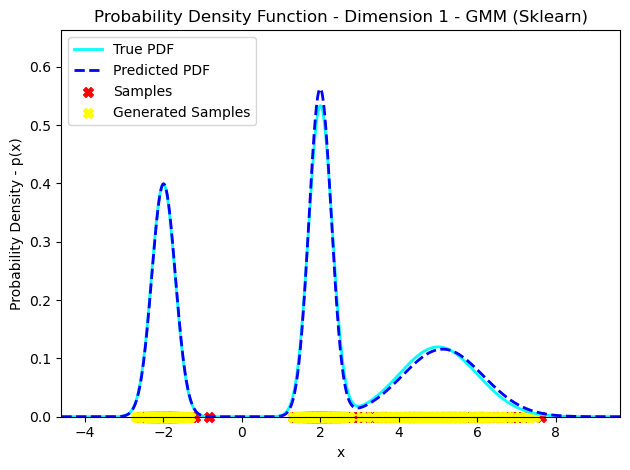

In [12]:
for d in range(D):
    x_values = np.linspace(min(data[:, d]) - 2, max(data[:, d]) + 2, 1000)

    # Plot true density
    density = np.zeros_like(x_values)
    for k in range(true_K):
        pdf = (1 / np.sqrt(2 * np.pi * true_variances[k, d])) * np.exp(-0.5 * ((x_values - true_means[k, d])**2) / true_variances[k, d])
        density += (true_weights[k] * pdf)
    plt.plot(x_values, density, color='cyan', linewidth=2, label='True PDF')

    # Plot predicted density
    pred_density = np.zeros_like(x_values)
    for k in range(K):
        pdf = (1 / np.sqrt(2 * np.pi * models['GMM (Sklearn)'].covariances_[k, d, d])) * np.exp(-0.5 * ((x_values - models['GMM (Sklearn)'].means_[k, d])**2) / models['GMM (Sklearn)'].covariances_[k, d, d])
        pred_density += (models['GMM (Sklearn)'].weights_[k] * pdf)
    plt.plot(x_values, pred_density, color='blue', linewidth=2, linestyle='--', label='Predicted PDF')

    # Plot samples generated from true density
    plt.scatter(data[:, d], np.zeros_like(data[:, d]), c='red', marker='X', s=50, label='Samples', clip_on=False)

    # Generate samples from the predicted density and plot
    data_samples, _ = models['GMM (Sklearn)'].sample(500)
    plt.scatter(data_samples[:, d], np.zeros_like(data_samples[:, d]), c='yellow', marker='X', s=50, label='Generated Samples', clip_on=False)

    plt.title(f'Probability Density Function - Dimension {d} - GMM (Sklearn)', fontsize=12)
    plt.ylabel('Probability Density - p(x)')
    plt.xlabel('x')
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.xlim(min(data[:, d]) - 2, max(data[:, d]) + 2)
    plt.ylim(0.0, max(max(density), max(pred_density)) + 0.1)
    plt.tight_layout()
    plt.show()